<a href="https://colab.research.google.com/github/agarr3/vajra-new/blob/main/AE_HYBRID_LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
criterion = nn.MSELoss()
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/"
DATA_SONG_DIR = "48Bins"
DATA_IMG_DIR = "48Bins"

files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_numpy"):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
files = random.sample(files, 2008)

for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Indian_numpy"):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

,Images,songs,labels
0,039357.npy,039357.npy,Western_numpy
1,107591.npy,107591.npy,Western_numpy
2,143217.npy,143217.npy,Western_numpy
3,140623.npy,140623.npy,Western_numpy
4,147059.npy,147059.npy,Western_numpy


In [6]:
dataDF.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2008,2008
Western_numpy,2008,2008


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_numpy/122646.npy
80.0


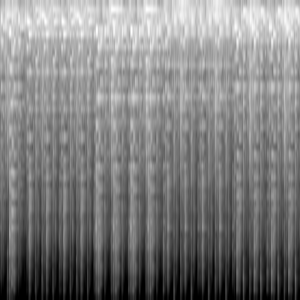

In [7]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



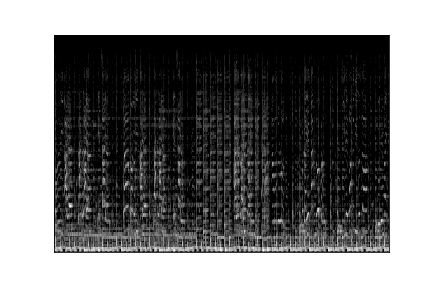

In [8]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [9]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

,Images,songs,labels,encoded_labels
0,039357.npy,039357.npy,Western_numpy,1
1,107591.npy,107591.npy,Western_numpy,1
2,143217.npy,143217.npy,Western_numpy,1
3,140623.npy,140623.npy,Western_numpy,1
4,147059.npy,147059.npy,Western_numpy,1


In [10]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2008,2008
Western_numpy,1,2008,2008


In [11]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]])

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1406,1406
Western_numpy,1,1405,1405


In [13]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,602,602
Western_numpy,1,603,603


In [14]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [15]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        return data, label



In [16]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [17]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [18]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

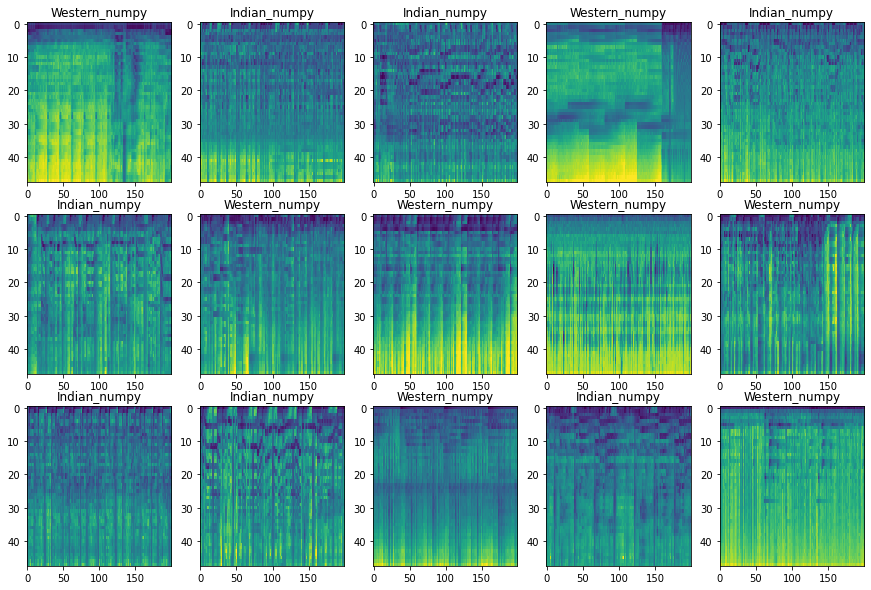

In [21]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

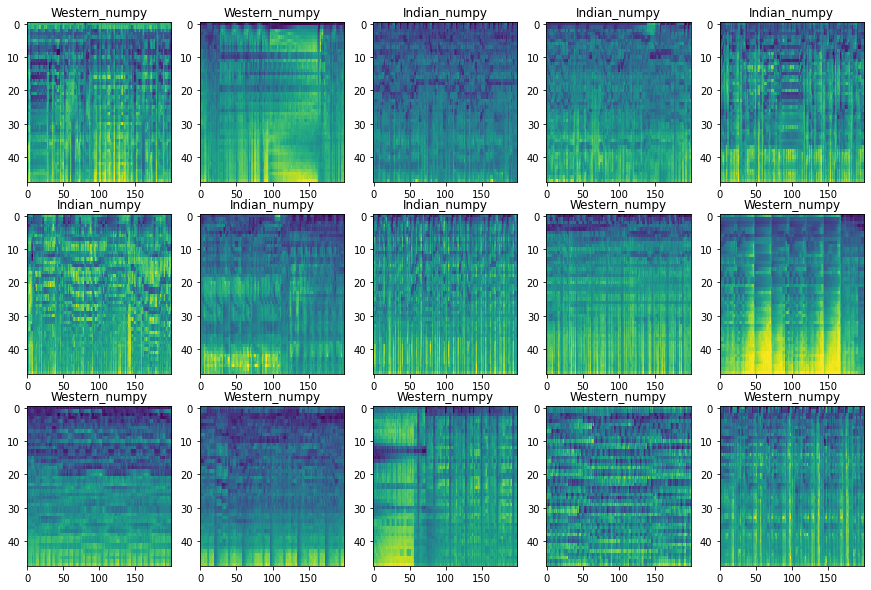

In [22]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [23]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [24]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1374.236
[1,     2] loss: 1267.409
[1,     3] loss: 1252.790
[1,     4] loss: 1081.727
[1,     5] loss: 960.874
[1,     6] loss: 968.427
[1,     7] loss: 603.065
[1,     8] loss: 317.185
[1,     9] loss: 192.481
[1,    10] loss: 414.648
[1,    11] loss: 237.275
[1,    12] loss: 111.869
[1,    13] loss: 127.260
[1,    14] loss: 144.110
[1,    15] loss: 201.653
[1,    16] loss: 244.865
[1,    17] loss: 211.411
[1,    18] loss: 133.978
[1,    19] loss: 126.838
[1,    20] loss: 145.471
[1,    21] loss: 118.151
[1,    22] loss: 157.202
[1,    23] loss: 161.742
[1,    24] loss: 177.886
[1,    25] loss: 143.417
[1,    26] loss: 132.076
[1,    27] loss: 127.313
[1,    28] loss: 128.672
[1,    29] loss: 117.195
[1,    30] loss: 114.977
[1,    31] loss: 132.066
[1,    32] loss: 156.367
[1,    33] loss: 143.533
[1,    34] loss: 119.326
[1,    35] loss: 124.619
[1,    36] loss: 118.943
[1,    37] loss: 111.572
[1,    38] loss: 121.357
[1,    39] loss: 137.234
[1,    40] loss: 115.

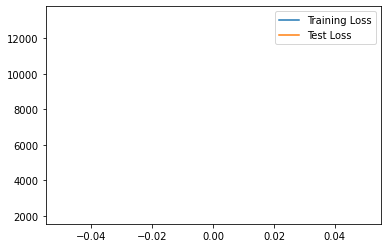

[2,     1] loss: 109.275
[2,     2] loss: 92.970
[2,     3] loss: 99.770
[2,     4] loss: 98.760
[2,     5] loss: 99.310
[2,     6] loss: 124.911
[2,     7] loss: 118.174
[2,     8] loss: 114.029
[2,     9] loss: 103.175
[2,    10] loss: 100.549
[2,    11] loss: 95.984
[2,    12] loss: 92.077
[2,    13] loss: 101.351
[2,    14] loss: 93.667
[2,    15] loss: 106.073
[2,    16] loss: 124.232
[2,    17] loss: 105.787
[2,    18] loss: 94.165
[2,    19] loss: 95.654
[2,    20] loss: 116.830
[2,    21] loss: 95.922
[2,    22] loss: 115.600
[2,    23] loss: 101.904
[2,    24] loss: 120.768
[2,    25] loss: 92.696
[2,    26] loss: 108.555
[2,    27] loss: 113.633
[2,    28] loss: 110.111
[2,    29] loss: 100.303
[2,    30] loss: 95.798
[2,    31] loss: 100.394
[2,    32] loss: 113.890
[2,    33] loss: 104.559
[2,    34] loss: 91.223
[2,    35] loss: 99.515
[2,    36] loss: 92.873
[2,    37] loss: 83.555
[2,    38] loss: 89.121
[2,    39] loss: 96.881
[2,    40] loss: 84.831
[2,    41] loss: 81

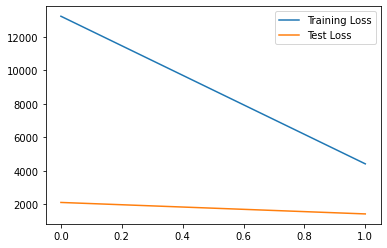

[3,     1] loss: 74.104
[3,     2] loss: 72.279
[3,     3] loss: 71.183
[3,     4] loss: 69.363
[3,     5] loss: 72.091
[3,     6] loss: 76.709
[3,     7] loss: 78.769
[3,     8] loss: 70.560
[3,     9] loss: 66.806
[3,    10] loss: 70.470
[3,    11] loss: 62.827
[3,    12] loss: 66.727
[3,    13] loss: 75.993
[3,    14] loss: 69.782
[3,    15] loss: 74.525
[3,    16] loss: 84.073
[3,    17] loss: 75.365
[3,    18] loss: 68.137
[3,    19] loss: 68.312
[3,    20] loss: 73.048
[3,    21] loss: 67.914
[3,    22] loss: 84.647
[3,    23] loss: 73.131
[3,    24] loss: 83.440
[3,    25] loss: 65.424
[3,    26] loss: 70.081
[3,    27] loss: 80.278
[3,    28] loss: 74.675
[3,    29] loss: 71.734
[3,    30] loss: 67.157
[3,    31] loss: 68.992
[3,    32] loss: 77.077
[3,    33] loss: 68.890
[3,    34] loss: 66.897
[3,    35] loss: 73.967
[3,    36] loss: 70.759
[3,    37] loss: 67.482
[3,    38] loss: 74.462
[3,    39] loss: 76.158
[3,    40] loss: 69.670
[3,    41] loss: 66.972
[3,    42] loss:

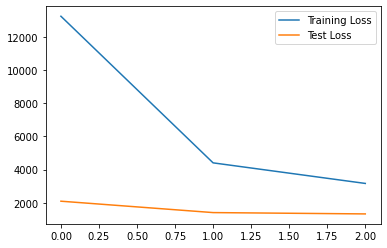

[4,     1] loss: 70.133
[4,     2] loss: 68.417
[4,     3] loss: 68.009
[4,     4] loss: 66.859
[4,     5] loss: 68.554
[4,     6] loss: 71.863
[4,     7] loss: 72.501
[4,     8] loss: 66.901
[4,     9] loss: 65.472
[4,    10] loss: 68.301
[4,    11] loss: 61.609
[4,    12] loss: 64.297
[4,    13] loss: 75.199
[4,    14] loss: 68.126
[4,    15] loss: 73.697
[4,    16] loss: 82.440
[4,    17] loss: 74.603
[4,    18] loss: 66.635
[4,    19] loss: 67.229
[4,    20] loss: 71.493
[4,    21] loss: 66.610
[4,    22] loss: 83.152
[4,    23] loss: 72.481
[4,    24] loss: 82.303
[4,    25] loss: 64.893
[4,    26] loss: 68.707
[4,    27] loss: 79.514
[4,    28] loss: 74.451
[4,    29] loss: 71.000
[4,    30] loss: 66.964
[4,    31] loss: 68.060
[4,    32] loss: 75.915
[4,    33] loss: 68.720
[4,    34] loss: 66.052
[4,    35] loss: 73.615
[4,    36] loss: 70.628
[4,    37] loss: 66.593
[4,    38] loss: 73.908
[4,    39] loss: 74.983
[4,    40] loss: 69.528
[4,    41] loss: 66.446
[4,    42] loss:

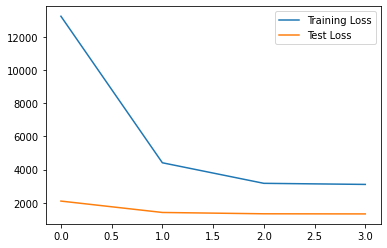

[5,     1] loss: 69.632
[5,     2] loss: 67.827
[5,     3] loss: 67.594
[5,     4] loss: 66.083
[5,     5] loss: 68.185
[5,     6] loss: 70.870
[5,     7] loss: 72.082
[5,     8] loss: 66.631
[5,     9] loss: 64.928
[5,    10] loss: 68.098
[5,    11] loss: 61.365
[5,    12] loss: 64.080
[5,    13] loss: 74.832
[5,    14] loss: 67.788
[5,    15] loss: 73.287
[5,    16] loss: 81.622
[5,    17] loss: 74.123
[5,    18] loss: 66.506
[5,    19] loss: 66.792
[5,    20] loss: 71.191
[5,    21] loss: 66.588
[5,    22] loss: 82.636
[5,    23] loss: 72.359
[5,    24] loss: 81.931
[5,    25] loss: 64.586
[5,    26] loss: 68.515
[5,    27] loss: 79.009
[5,    28] loss: 74.171
[5,    29] loss: 70.709
[5,    30] loss: 66.655
[5,    31] loss: 67.862
[5,    32] loss: 74.975
[5,    33] loss: 68.294
[5,    34] loss: 65.702
[5,    35] loss: 72.646
[5,    36] loss: 70.541
[5,    37] loss: 66.187
[5,    38] loss: 73.424
[5,    39] loss: 74.343
[5,    40] loss: 69.230
[5,    41] loss: 66.032
[5,    42] loss:

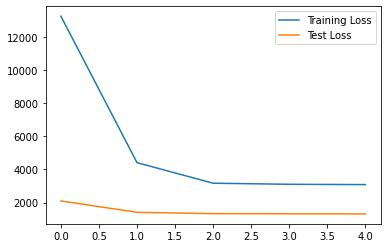

[6,     1] loss: 69.174
[6,     2] loss: 67.462
[6,     3] loss: 67.197
[6,     4] loss: 65.623
[6,     5] loss: 67.793
[6,     6] loss: 70.431
[6,     7] loss: 71.744
[6,     8] loss: 66.455
[6,     9] loss: 64.512
[6,    10] loss: 67.592
[6,    11] loss: 61.029
[6,    12] loss: 63.811
[6,    13] loss: 74.377
[6,    14] loss: 67.494
[6,    15] loss: 72.990
[6,    16] loss: 81.071
[6,    17] loss: 73.567
[6,    18] loss: 66.110
[6,    19] loss: 66.244
[6,    20] loss: 70.597
[6,    21] loss: 66.135
[6,    22] loss: 82.159
[6,    23] loss: 71.787
[6,    24] loss: 81.500
[6,    25] loss: 64.063
[6,    26] loss: 67.933
[6,    27] loss: 78.434
[6,    28] loss: 73.075
[6,    29] loss: 70.277
[6,    30] loss: 66.213
[6,    31] loss: 67.107
[6,    32] loss: 74.259
[6,    33] loss: 67.391
[6,    34] loss: 65.154
[6,    35] loss: 71.938
[6,    36] loss: 69.489
[6,    37] loss: 65.557
[6,    38] loss: 72.821
[6,    39] loss: 73.517
[6,    40] loss: 69.076
[6,    41] loss: 65.372
[6,    42] loss:

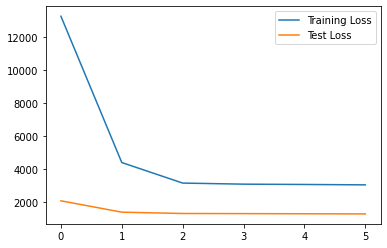

[7,     1] loss: 68.628
[7,     2] loss: 67.120
[7,     3] loss: 66.673
[7,     4] loss: 65.049
[7,     5] loss: 67.367
[7,     6] loss: 69.770
[7,     7] loss: 71.435
[7,     8] loss: 66.417
[7,     9] loss: 64.120
[7,    10] loss: 67.066
[7,    11] loss: 60.730
[7,    12] loss: 63.600
[7,    13] loss: 73.772
[7,    14] loss: 67.144
[7,    15] loss: 72.877
[7,    16] loss: 80.665
[7,    17] loss: 72.999
[7,    18] loss: 65.795
[7,    19] loss: 65.375
[7,    20] loss: 69.983
[7,    21] loss: 65.911
[7,    22] loss: 81.573
[7,    23] loss: 71.111
[7,    24] loss: 80.974
[7,    25] loss: 63.694
[7,    26] loss: 67.224
[7,    27] loss: 77.613
[7,    28] loss: 72.167
[7,    29] loss: 69.395
[7,    30] loss: 65.742
[7,    31] loss: 66.302
[7,    32] loss: 73.549
[7,    33] loss: 67.090
[7,    34] loss: 64.473
[7,    35] loss: 71.564
[7,    36] loss: 69.387
[7,    37] loss: 65.190
[7,    38] loss: 71.965
[7,    39] loss: 72.933
[7,    40] loss: 69.019
[7,    41] loss: 64.706
[7,    42] loss:

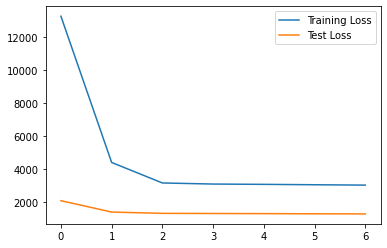

[8,     1] loss: 68.057
[8,     2] loss: 66.392
[8,     3] loss: 65.901
[8,     4] loss: 64.808
[8,     5] loss: 66.908
[8,     6] loss: 68.814
[8,     7] loss: 71.036
[8,     8] loss: 66.301
[8,     9] loss: 63.383
[8,    10] loss: 66.588
[8,    11] loss: 59.881
[8,    12] loss: 62.968
[8,    13] loss: 72.759
[8,    14] loss: 66.365
[8,    15] loss: 71.980
[8,    16] loss: 79.815
[8,    17] loss: 72.714
[8,    18] loss: 67.026
[8,    19] loss: 63.899
[8,    20] loss: 69.459
[8,    21] loss: 66.958
[8,    22] loss: 79.976
[8,    23] loss: 71.209
[8,    24] loss: 80.604
[8,    25] loss: 62.898
[8,    26] loss: 67.326
[8,    27] loss: 75.926
[8,    28] loss: 71.690
[8,    29] loss: 69.137
[8,    30] loss: 64.295
[8,    31] loss: 64.681
[8,    32] loss: 72.288
[8,    33] loss: 66.114
[8,    34] loss: 62.835
[8,    35] loss: 69.598
[8,    36] loss: 66.960
[8,    37] loss: 63.318
[8,    38] loss: 69.570
[8,    39] loss: 70.917
[8,    40] loss: 66.641
[8,    41] loss: 62.266
[8,    42] loss:

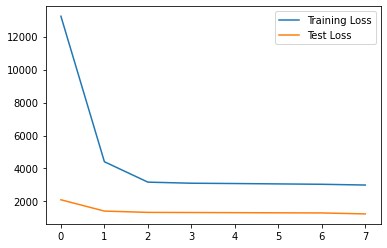

[9,     1] loss: 64.793
[9,     2] loss: 64.048
[9,     3] loss: 62.885
[9,     4] loss: 61.774
[9,     5] loss: 64.021
[9,     6] loss: 65.861
[9,     7] loss: 66.642
[9,     8] loss: 63.054
[9,     9] loss: 60.915
[9,    10] loss: 64.439
[9,    11] loss: 56.224
[9,    12] loss: 59.226
[9,    13] loss: 66.580
[9,    14] loss: 63.122
[9,    15] loss: 68.337
[9,    16] loss: 73.329
[9,    17] loss: 66.780
[9,    18] loss: 63.298
[9,    19] loss: 60.043
[9,    20] loss: 63.262
[9,    21] loss: 62.763
[9,    22] loss: 73.975
[9,    23] loss: 63.771
[9,    24] loss: 75.250
[9,    25] loss: 59.055
[9,    26] loss: 63.164
[9,    27] loss: 70.983
[9,    28] loss: 67.825
[9,    29] loss: 64.146
[9,    30] loss: 58.991
[9,    31] loss: 58.494
[9,    32] loss: 68.100
[9,    33] loss: 62.133
[9,    34] loss: 58.129
[9,    35] loss: 65.605
[9,    36] loss: 62.129
[9,    37] loss: 59.386
[9,    38] loss: 64.084
[9,    39] loss: 65.540
[9,    40] loss: 63.553
[9,    41] loss: 58.339
[9,    42] loss:

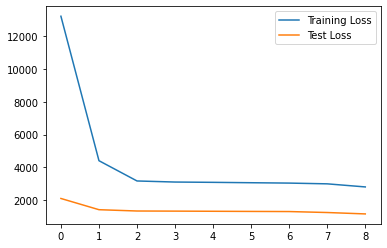

[10,     1] loss: 60.285
[10,     2] loss: 60.490
[10,     3] loss: 59.361
[10,     4] loss: 58.649
[10,     5] loss: 60.061
[10,     6] loss: 63.389
[10,     7] loss: 60.572
[10,     8] loss: 58.057
[10,     9] loss: 58.473
[10,    10] loss: 61.314
[10,    11] loss: 53.536
[10,    12] loss: 56.610
[10,    13] loss: 61.854
[10,    14] loss: 58.874
[10,    15] loss: 65.464
[10,    16] loss: 69.110
[10,    17] loss: 62.452
[10,    18] loss: 56.823
[10,    19] loss: 56.890
[10,    20] loss: 59.310
[10,    21] loss: 57.721
[10,    22] loss: 69.376
[10,    23] loss: 59.528
[10,    24] loss: 70.763
[10,    25] loss: 57.375
[10,    26] loss: 59.449
[10,    27] loss: 66.194
[10,    28] loss: 65.281
[10,    29] loss: 60.184
[10,    30] loss: 56.921
[10,    31] loss: 56.412
[10,    32] loss: 64.936
[10,    33] loss: 60.132
[10,    34] loss: 55.394
[10,    35] loss: 63.711
[10,    36] loss: 60.739
[10,    37] loss: 57.174
[10,    38] loss: 61.544
[10,    39] loss: 62.919
[10,    40] loss: 61.398


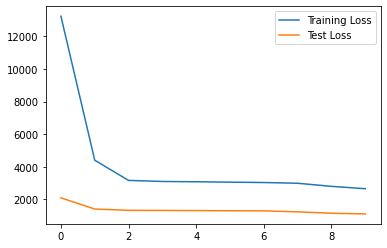

[11,     1] loss: 57.527
[11,     2] loss: 59.041
[11,     3] loss: 56.960
[11,     4] loss: 56.605
[11,     5] loss: 58.019
[11,     6] loss: 61.791
[11,     7] loss: 57.664
[11,     8] loss: 56.312
[11,     9] loss: 56.530
[11,    10] loss: 59.653
[11,    11] loss: 51.270
[11,    12] loss: 55.057
[11,    13] loss: 58.985
[11,    14] loss: 56.137
[11,    15] loss: 63.582
[11,    16] loss: 66.454
[11,    17] loss: 59.675
[11,    18] loss: 55.456
[11,    19] loss: 55.381
[11,    20] loss: 58.231
[11,    21] loss: 55.613
[11,    22] loss: 66.840
[11,    23] loss: 57.369
[11,    24] loss: 67.682
[11,    25] loss: 56.055
[11,    26] loss: 56.922
[11,    27] loss: 63.618
[11,    28] loss: 62.502
[11,    29] loss: 57.638
[11,    30] loss: 54.713
[11,    31] loss: 54.643
[11,    32] loss: 62.549
[11,    33] loss: 57.948
[11,    34] loss: 53.507
[11,    35] loss: 62.208
[11,    36] loss: 58.239
[11,    37] loss: 55.926
[11,    38] loss: 58.544
[11,    39] loss: 60.457
[11,    40] loss: 58.341


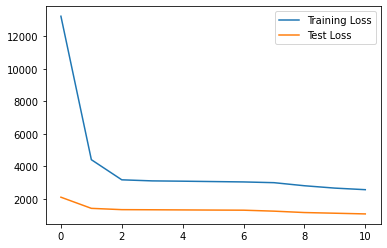

[12,     1] loss: 54.858
[12,     2] loss: 56.952
[12,     3] loss: 54.257
[12,     4] loss: 55.281
[12,     5] loss: 54.652
[12,     6] loss: 59.366
[12,     7] loss: 56.079
[12,     8] loss: 55.294
[12,     9] loss: 54.546
[12,    10] loss: 56.935
[12,    11] loss: 51.448
[12,    12] loss: 53.138
[12,    13] loss: 57.083
[12,    14] loss: 54.954
[12,    15] loss: 60.499
[12,    16] loss: 63.760
[12,    17] loss: 57.504
[12,    18] loss: 52.933
[12,    19] loss: 53.254
[12,    20] loss: 56.217
[12,    21] loss: 53.951
[12,    22] loss: 62.947
[12,    23] loss: 56.662
[12,    24] loss: 64.913
[12,    25] loss: 54.471
[12,    26] loss: 54.492
[12,    27] loss: 60.997
[12,    28] loss: 59.573
[12,    29] loss: 54.608
[12,    30] loss: 53.422
[12,    31] loss: 52.805
[12,    32] loss: 60.447
[12,    33] loss: 56.651
[12,    34] loss: 51.434
[12,    35] loss: 60.598
[12,    36] loss: 56.212
[12,    37] loss: 55.471
[12,    38] loss: 56.126
[12,    39] loss: 58.417
[12,    40] loss: 56.297


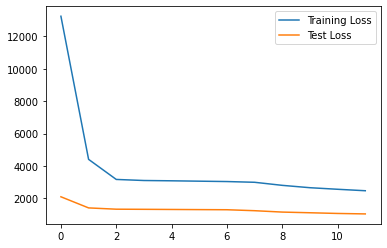

[13,     1] loss: 53.801
[13,     2] loss: 55.125
[13,     3] loss: 52.748
[13,     4] loss: 53.704
[13,     5] loss: 53.133
[13,     6] loss: 57.219
[13,     7] loss: 53.977
[13,     8] loss: 54.336
[13,     9] loss: 52.660
[13,    10] loss: 55.175
[13,    11] loss: 48.813
[13,    12] loss: 51.385
[13,    13] loss: 54.287
[13,    14] loss: 52.504
[13,    15] loss: 58.601
[13,    16] loss: 61.559
[13,    17] loss: 55.459
[13,    18] loss: 51.239
[13,    19] loss: 51.246
[13,    20] loss: 54.564
[13,    21] loss: 51.570
[13,    22] loss: 60.971
[13,    23] loss: 54.392
[13,    24] loss: 62.287
[13,    25] loss: 53.058
[13,    26] loss: 52.985
[13,    27] loss: 59.438
[13,    28] loss: 57.625
[13,    29] loss: 53.030
[13,    30] loss: 51.859
[13,    31] loss: 51.624
[13,    32] loss: 58.423
[13,    33] loss: 55.008
[13,    34] loss: 49.900
[13,    35] loss: 58.476
[13,    36] loss: 54.547
[13,    37] loss: 53.830
[13,    38] loss: 54.751
[13,    39] loss: 56.333
[13,    40] loss: 54.762


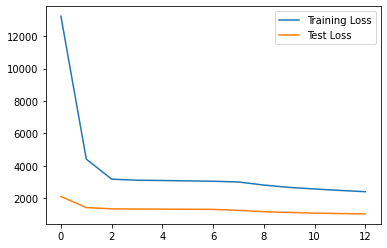

[14,     1] loss: 52.759
[14,     2] loss: 53.820
[14,     3] loss: 51.261
[14,     4] loss: 53.613
[14,     5] loss: 52.099
[14,     6] loss: 56.276
[14,     7] loss: 53.067
[14,     8] loss: 52.719
[14,     9] loss: 52.309
[14,    10] loss: 53.989
[14,    11] loss: 47.560
[14,    12] loss: 50.794
[14,    13] loss: 52.907
[14,    14] loss: 51.544
[14,    15] loss: 58.061
[14,    16] loss: 59.584
[14,    17] loss: 54.208
[14,    18] loss: 51.313
[14,    19] loss: 49.863
[14,    20] loss: 53.307
[14,    21] loss: 51.034
[14,    22] loss: 59.202
[14,    23] loss: 53.317
[14,    24] loss: 60.981
[14,    25] loss: 51.532
[14,    26] loss: 51.775
[14,    27] loss: 58.816
[14,    28] loss: 55.464
[14,    29] loss: 51.878
[14,    30] loss: 51.356
[14,    31] loss: 50.018
[14,    32] loss: 57.418
[14,    33] loss: 53.787
[14,    34] loss: 48.782
[14,    35] loss: 57.609
[14,    36] loss: 53.184
[14,    37] loss: 52.798
[14,    38] loss: 53.471
[14,    39] loss: 54.206
[14,    40] loss: 53.604


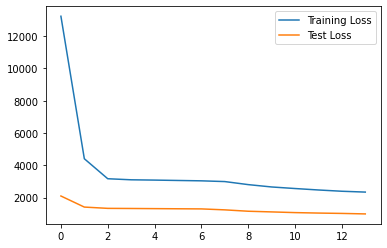

[15,     1] loss: 50.802
[15,     2] loss: 51.558
[15,     3] loss: 49.531
[15,     4] loss: 51.659
[15,     5] loss: 50.020
[15,     6] loss: 54.903
[15,     7] loss: 49.892
[15,     8] loss: 51.303
[15,     9] loss: 50.560
[15,    10] loss: 51.738
[15,    11] loss: 46.871
[15,    12] loss: 48.973
[15,    13] loss: 51.649
[15,    14] loss: 50.846
[15,    15] loss: 55.116
[15,    16] loss: 58.551
[15,    17] loss: 53.573
[15,    18] loss: 49.223
[15,    19] loss: 49.007
[15,    20] loss: 51.778
[15,    21] loss: 49.154
[15,    22] loss: 57.519
[15,    23] loss: 52.093
[15,    24] loss: 58.685
[15,    25] loss: 50.171
[15,    26] loss: 49.913
[15,    27] loss: 56.701
[15,    28] loss: 53.518
[15,    29] loss: 50.169
[15,    30] loss: 49.406
[15,    31] loss: 48.564
[15,    32] loss: 55.469
[15,    33] loss: 51.922
[15,    34] loss: 47.956
[15,    35] loss: 55.297
[15,    36] loss: 51.540
[15,    37] loss: 51.682
[15,    38] loss: 51.690
[15,    39] loss: 52.752
[15,    40] loss: 51.755


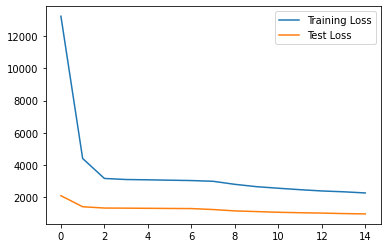

[16,     1] loss: 49.788
[16,     2] loss: 50.486
[16,     3] loss: 48.706
[16,     4] loss: 50.736
[16,     5] loss: 49.313
[16,     6] loss: 53.433
[16,     7] loss: 48.167
[16,     8] loss: 50.146
[16,     9] loss: 49.057
[16,    10] loss: 50.590
[16,    11] loss: 45.356
[16,    12] loss: 47.759
[16,    13] loss: 50.387
[16,    14] loss: 49.254
[16,    15] loss: 54.183
[16,    16] loss: 56.357
[16,    17] loss: 51.326
[16,    18] loss: 47.981
[16,    19] loss: 47.444
[16,    20] loss: 50.622
[16,    21] loss: 47.914
[16,    22] loss: 55.465
[16,    23] loss: 50.936
[16,    24] loss: 57.284
[16,    25] loss: 48.869
[16,    26] loss: 48.594
[16,    27] loss: 55.200
[16,    28] loss: 51.966
[16,    29] loss: 48.773
[16,    30] loss: 48.495
[16,    31] loss: 47.076
[16,    32] loss: 54.181
[16,    33] loss: 50.542
[16,    34] loss: 46.752
[16,    35] loss: 53.758
[16,    36] loss: 50.406
[16,    37] loss: 50.444
[16,    38] loss: 50.420
[16,    39] loss: 51.196
[16,    40] loss: 50.239


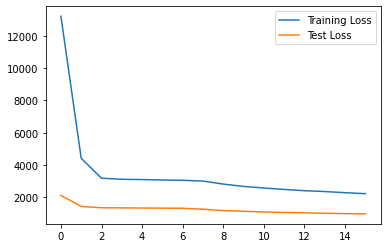

[17,     1] loss: 48.790
[17,     2] loss: 49.561
[17,     3] loss: 47.469
[17,     4] loss: 49.916
[17,     5] loss: 48.214
[17,     6] loss: 52.335
[17,     7] loss: 46.854
[17,     8] loss: 49.124
[17,     9] loss: 47.911
[17,    10] loss: 49.639
[17,    11] loss: 44.342
[17,    12] loss: 47.075
[17,    13] loss: 48.861
[17,    14] loss: 48.034
[17,    15] loss: 53.220
[17,    16] loss: 54.436
[17,    17] loss: 49.964
[17,    18] loss: 47.088
[17,    19] loss: 46.403
[17,    20] loss: 49.737
[17,    21] loss: 46.903
[17,    22] loss: 53.729
[17,    23] loss: 50.032
[17,    24] loss: 56.074
[17,    25] loss: 47.788
[17,    26] loss: 47.410
[17,    27] loss: 54.074
[17,    28] loss: 50.519
[17,    29] loss: 47.633
[17,    30] loss: 47.655
[17,    31] loss: 45.868
[17,    32] loss: 53.086
[17,    33] loss: 49.315
[17,    34] loss: 45.668
[17,    35] loss: 52.421
[17,    36] loss: 49.694
[17,    37] loss: 49.190
[17,    38] loss: 49.368
[17,    39] loss: 49.999
[17,    40] loss: 49.144


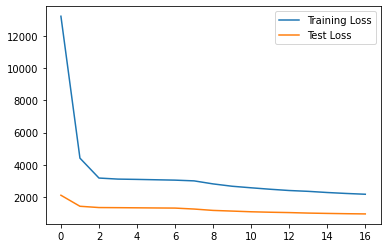

[18,     1] loss: 47.863
[18,     2] loss: 48.794
[18,     3] loss: 46.456
[18,     4] loss: 49.048
[18,     5] loss: 47.172
[18,     6] loss: 51.401
[18,     7] loss: 45.494
[18,     8] loss: 48.169
[18,     9] loss: 46.676
[18,    10] loss: 48.676
[18,    11] loss: 43.392
[18,    12] loss: 46.435
[18,    13] loss: 47.744
[18,    14] loss: 47.198
[18,    15] loss: 52.186
[18,    16] loss: 53.258
[18,    17] loss: 48.525
[18,    18] loss: 46.269
[18,    19] loss: 45.459
[18,    20] loss: 48.866
[18,    21] loss: 46.104
[18,    22] loss: 52.231
[18,    23] loss: 49.252
[18,    24] loss: 54.945
[18,    25] loss: 46.801
[18,    26] loss: 46.435
[18,    27] loss: 53.131
[18,    28] loss: 49.504
[18,    29] loss: 46.719
[18,    30] loss: 46.731
[18,    31] loss: 45.044
[18,    32] loss: 52.153
[18,    33] loss: 48.324
[18,    34] loss: 44.995
[18,    35] loss: 51.553
[18,    36] loss: 48.836
[18,    37] loss: 48.234
[18,    38] loss: 48.377
[18,    39] loss: 48.948
[18,    40] loss: 48.165


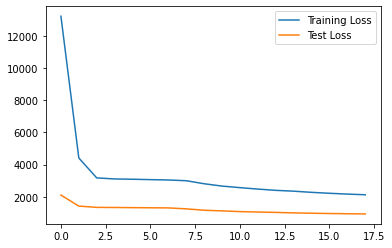

[19,     1] loss: 47.066
[19,     2] loss: 47.846
[19,     3] loss: 45.703
[19,     4] loss: 48.231
[19,     5] loss: 46.217
[19,     6] loss: 50.619
[19,     7] loss: 44.680
[19,     8] loss: 47.236
[19,     9] loss: 45.727
[19,    10] loss: 47.687
[19,    11] loss: 42.550
[19,    12] loss: 45.387
[19,    13] loss: 47.051
[19,    14] loss: 46.238
[19,    15] loss: 51.359
[19,    16] loss: 52.161
[19,    17] loss: 47.619
[19,    18] loss: 45.349
[19,    19] loss: 44.640
[19,    20] loss: 47.951
[19,    21] loss: 45.375
[19,    22] loss: 51.155
[19,    23] loss: 48.409
[19,    24] loss: 54.107
[19,    25] loss: 46.251
[19,    26] loss: 45.534
[19,    27] loss: 52.381
[19,    28] loss: 48.405
[19,    29] loss: 45.787
[19,    30] loss: 46.200
[19,    31] loss: 43.955
[19,    32] loss: 51.179
[19,    33] loss: 47.679
[19,    34] loss: 44.112
[19,    35] loss: 50.736
[19,    36] loss: 47.989
[19,    37] loss: 47.445
[19,    38] loss: 47.697
[19,    39] loss: 48.021
[19,    40] loss: 47.544


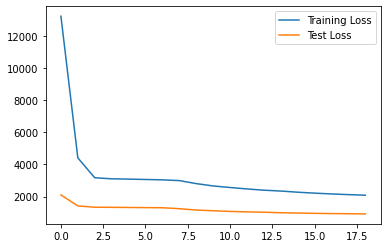

[20,     1] loss: 46.281
[20,     2] loss: 46.880
[20,     3] loss: 45.043
[20,     4] loss: 47.364
[20,     5] loss: 45.459
[20,     6] loss: 49.539
[20,     7] loss: 44.020
[20,     8] loss: 46.451
[20,     9] loss: 44.876
[20,    10] loss: 46.837
[20,    11] loss: 41.881
[20,    12] loss: 44.381
[20,    13] loss: 46.202
[20,    14] loss: 45.555
[20,    15] loss: 50.286
[20,    16] loss: 51.154
[20,    17] loss: 46.914
[20,    18] loss: 44.802
[20,    19] loss: 43.815
[20,    20] loss: 47.218
[20,    21] loss: 45.039
[20,    22] loss: 50.047
[20,    23] loss: 47.587
[20,    24] loss: 53.166
[20,    25] loss: 45.386
[20,    26] loss: 44.667
[20,    27] loss: 51.564
[20,    28] loss: 47.551
[20,    29] loss: 45.208
[20,    30] loss: 45.509
[20,    31] loss: 43.276
[20,    32] loss: 50.435
[20,    33] loss: 46.821
[20,    34] loss: 43.523
[20,    35] loss: 50.272
[20,    36] loss: 47.377
[20,    37] loss: 46.862
[20,    38] loss: 46.893
[20,    39] loss: 47.281
[20,    40] loss: 46.686


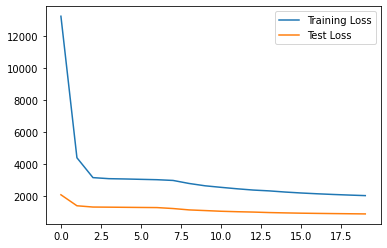

[21,     1] loss: 45.535
[21,     2] loss: 46.123
[21,     3] loss: 44.330
[21,     4] loss: 46.533
[21,     5] loss: 44.700
[21,     6] loss: 48.613
[21,     7] loss: 43.101
[21,     8] loss: 45.649
[21,     9] loss: 44.212
[21,    10] loss: 46.020
[21,    11] loss: 41.346
[21,    12] loss: 43.538
[21,    13] loss: 45.459
[21,    14] loss: 44.826
[21,    15] loss: 49.434
[21,    16] loss: 50.118
[21,    17] loss: 46.181
[21,    18] loss: 44.214
[21,    19] loss: 43.112
[21,    20] loss: 46.495
[21,    21] loss: 44.507
[21,    22] loss: 49.014
[21,    23] loss: 46.830
[21,    24] loss: 52.288
[21,    25] loss: 44.646
[21,    26] loss: 43.864
[21,    27] loss: 50.790
[21,    28] loss: 46.606
[21,    29] loss: 44.423
[21,    30] loss: 44.813
[21,    31] loss: 42.603
[21,    32] loss: 49.497
[21,    33] loss: 45.983
[21,    34] loss: 43.013
[21,    35] loss: 49.610
[21,    36] loss: 46.705
[21,    37] loss: 46.268
[21,    38] loss: 46.125
[21,    39] loss: 46.614
[21,    40] loss: 45.943


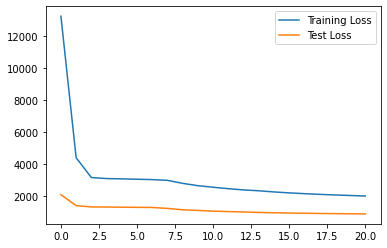

[22,     1] loss: 44.902
[22,     2] loss: 45.577
[22,     3] loss: 43.693
[22,     4] loss: 45.896
[22,     5] loss: 43.902
[22,     6] loss: 48.003
[22,     7] loss: 42.221
[22,     8] loss: 45.045
[22,     9] loss: 43.539
[22,    10] loss: 45.385
[22,    11] loss: 40.867
[22,    12] loss: 42.864
[22,    13] loss: 45.027
[22,    14] loss: 44.037
[22,    15] loss: 48.802
[22,    16] loss: 49.131
[22,    17] loss: 45.711
[22,    18] loss: 43.637
[22,    19] loss: 42.521
[22,    20] loss: 45.781
[22,    21] loss: 44.121
[22,    22] loss: 47.965
[22,    23] loss: 46.121
[22,    24] loss: 51.551
[22,    25] loss: 43.988
[22,    26] loss: 43.053
[22,    27] loss: 50.186
[22,    28] loss: 45.890
[22,    29] loss: 43.541
[22,    30] loss: 44.190
[22,    31] loss: 41.944
[22,    32] loss: 48.524
[22,    33] loss: 45.170
[22,    34] loss: 42.191
[22,    35] loss: 48.348
[22,    36] loss: 45.882
[22,    37] loss: 45.280
[22,    38] loss: 45.376
[22,    39] loss: 45.727
[22,    40] loss: 45.053


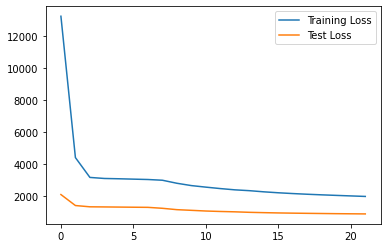

[23,     1] loss: 44.284
[23,     2] loss: 44.700
[23,     3] loss: 43.012
[23,     4] loss: 45.174
[23,     5] loss: 43.066
[23,     6] loss: 47.216
[23,     7] loss: 41.250
[23,     8] loss: 44.322
[23,     9] loss: 42.604
[23,    10] loss: 44.743
[23,    11] loss: 40.126
[23,    12] loss: 42.235
[23,    13] loss: 44.142
[23,    14] loss: 43.235
[23,    15] loss: 47.905
[23,    16] loss: 48.097
[23,    17] loss: 44.810
[23,    18] loss: 42.739
[23,    19] loss: 41.750
[23,    20] loss: 44.773
[23,    21] loss: 43.086
[23,    22] loss: 46.831
[23,    23] loss: 45.345
[23,    24] loss: 50.350
[23,    25] loss: 43.278
[23,    26] loss: 42.234
[23,    27] loss: 49.372
[23,    28] loss: 44.638
[23,    29] loss: 42.672
[23,    30] loss: 43.720
[23,    31] loss: 41.151
[23,    32] loss: 47.500
[23,    33] loss: 44.419
[23,    34] loss: 41.972
[23,    35] loss: 48.003
[23,    36] loss: 45.095
[23,    37] loss: 44.400
[23,    38] loss: 44.627
[23,    39] loss: 45.016
[23,    40] loss: 44.446


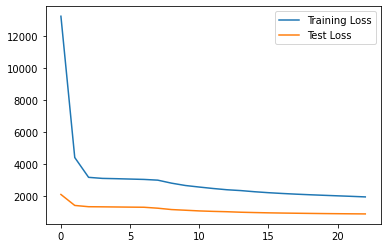

[24,     1] loss: 43.745
[24,     2] loss: 43.899
[24,     3] loss: 42.439
[24,     4] loss: 44.386
[24,     5] loss: 42.444
[24,     6] loss: 46.297
[24,     7] loss: 40.776
[24,     8] loss: 43.358
[24,     9] loss: 42.013
[24,    10] loss: 43.835
[24,    11] loss: 39.539
[24,    12] loss: 41.466
[24,    13] loss: 43.199
[24,    14] loss: 42.508
[24,    15] loss: 46.877
[24,    16] loss: 47.292
[24,    17] loss: 43.848
[24,    18] loss: 42.201
[24,    19] loss: 41.011
[24,    20] loss: 44.215
[24,    21] loss: 42.271
[24,    22] loss: 46.142
[24,    23] loss: 44.553
[24,    24] loss: 49.777
[24,    25] loss: 42.280
[24,    26] loss: 41.847
[24,    27] loss: 48.613
[24,    28] loss: 44.094
[24,    29] loss: 42.138
[24,    30] loss: 43.169
[24,    31] loss: 40.808
[24,    32] loss: 46.398
[24,    33] loss: 44.810
[24,    34] loss: 40.839
[24,    35] loss: 47.596
[24,    36] loss: 43.800
[24,    37] loss: 43.924
[24,    38] loss: 43.974
[24,    39] loss: 44.233
[24,    40] loss: 43.402


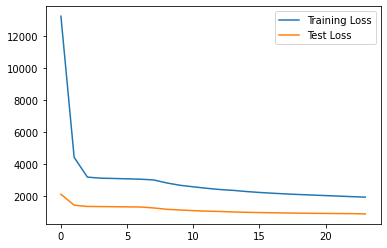

[25,     1] loss: 42.876
[25,     2] loss: 43.344
[25,     3] loss: 41.457
[25,     4] loss: 43.703
[25,     5] loss: 41.577
[25,     6] loss: 45.827
[25,     7] loss: 40.448
[25,     8] loss: 42.610
[25,     9] loss: 41.470
[25,    10] loss: 43.221
[25,    11] loss: 39.044
[25,    12] loss: 40.747
[25,    13] loss: 42.573
[25,    14] loss: 41.769
[25,    15] loss: 45.955
[25,    16] loss: 46.367
[25,    17] loss: 43.300
[25,    18] loss: 41.509
[25,    19] loss: 40.280
[25,    20] loss: 43.500
[25,    21] loss: 42.378
[25,    22] loss: 44.655
[25,    23] loss: 44.425
[25,    24] loss: 49.547
[25,    25] loss: 42.020
[25,    26] loss: 40.909
[25,    27] loss: 48.961
[25,    28] loss: 44.299
[25,    29] loss: 41.181
[25,    30] loss: 42.867
[25,    31] loss: 40.108
[25,    32] loss: 46.520
[25,    33] loss: 43.069
[25,    34] loss: 40.351
[25,    35] loss: 45.570
[25,    36] loss: 43.550
[25,    37] loss: 42.751
[25,    38] loss: 43.234
[25,    39] loss: 43.260
[25,    40] loss: 42.694


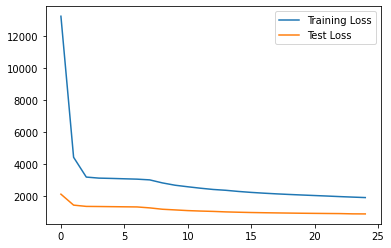

[26,     1] loss: 42.189
[26,     2] loss: 42.626
[26,     3] loss: 40.565
[26,     4] loss: 43.110
[26,     5] loss: 40.981
[26,     6] loss: 44.713
[26,     7] loss: 39.113
[26,     8] loss: 42.121
[26,     9] loss: 40.943
[26,    10] loss: 42.298
[26,    11] loss: 38.988
[26,    12] loss: 40.538
[26,    13] loss: 41.645
[26,    14] loss: 41.174
[26,    15] loss: 45.553
[26,    16] loss: 45.212
[26,    17] loss: 42.324
[26,    18] loss: 39.898
[26,    19] loss: 39.798
[26,    20] loss: 42.574
[26,    21] loss: 40.521
[26,    22] loss: 43.820
[26,    23] loss: 43.347
[26,    24] loss: 47.854
[26,    25] loss: 40.962
[26,    26] loss: 40.317
[26,    27] loss: 47.292
[26,    28] loss: 41.971
[26,    29] loss: 41.283
[26,    30] loss: 42.535
[26,    31] loss: 39.057
[26,    32] loss: 45.836
[26,    33] loss: 45.073
[26,    34] loss: 39.909
[26,    35] loss: 44.959
[26,    36] loss: 43.882
[26,    37] loss: 42.288
[26,    38] loss: 42.660
[26,    39] loss: 43.081
[26,    40] loss: 41.660


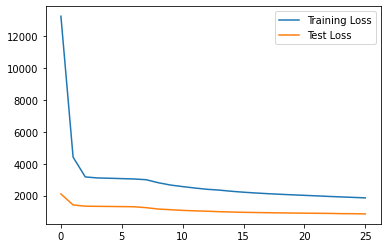

[27,     1] loss: 41.320
[27,     2] loss: 42.236
[27,     3] loss: 39.992
[27,     4] loss: 42.228
[27,     5] loss: 40.451
[27,     6] loss: 43.940
[27,     7] loss: 38.486
[27,     8] loss: 41.227
[27,     9] loss: 40.103
[27,    10] loss: 41.960
[27,    11] loss: 37.854
[27,    12] loss: 39.701
[27,    13] loss: 41.078
[27,    14] loss: 40.207
[27,    15] loss: 44.520
[27,    16] loss: 44.235
[27,    17] loss: 41.514
[27,    18] loss: 39.158
[27,    19] loss: 38.883
[27,    20] loss: 41.730
[27,    21] loss: 40.052
[27,    22] loss: 42.985
[27,    23] loss: 42.476
[27,    24] loss: 47.001
[27,    25] loss: 40.261
[27,    26] loss: 39.360
[27,    27] loss: 46.466
[27,    28] loss: 41.145
[27,    29] loss: 39.800
[27,    30] loss: 41.171
[27,    31] loss: 38.197
[27,    32] loss: 43.788
[27,    33] loss: 41.784
[27,    34] loss: 38.505
[27,    35] loss: 43.837
[27,    36] loss: 41.999
[27,    37] loss: 40.808
[27,    38] loss: 41.746
[27,    39] loss: 41.416
[27,    40] loss: 40.734


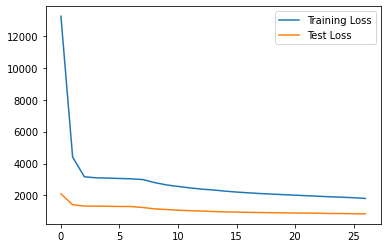

[28,     1] loss: 40.406
[28,     2] loss: 41.261
[28,     3] loss: 39.021
[28,     4] loss: 41.426
[28,     5] loss: 39.399
[28,     6] loss: 43.036
[28,     7] loss: 37.868
[28,     8] loss: 40.547
[28,     9] loss: 39.336
[28,    10] loss: 41.121
[28,    11] loss: 37.304
[28,    12] loss: 38.807
[28,    13] loss: 40.283
[28,    14] loss: 39.512
[28,    15] loss: 43.644
[28,    16] loss: 43.513
[28,    17] loss: 40.694
[28,    18] loss: 38.381
[28,    19] loss: 38.213
[28,    20] loss: 40.850
[28,    21] loss: 39.375
[28,    22] loss: 41.969
[28,    23] loss: 41.913
[28,    24] loss: 46.122
[28,    25] loss: 39.584
[28,    26] loss: 38.664
[28,    27] loss: 45.880
[28,    28] loss: 40.481
[28,    29] loss: 38.962
[28,    30] loss: 40.801
[28,    31] loss: 37.524
[28,    32] loss: 42.925
[28,    33] loss: 41.124
[28,    34] loss: 37.957
[28,    35] loss: 42.984
[28,    36] loss: 41.255
[28,    37] loss: 39.963
[28,    38] loss: 40.899
[28,    39] loss: 40.325
[28,    40] loss: 39.984


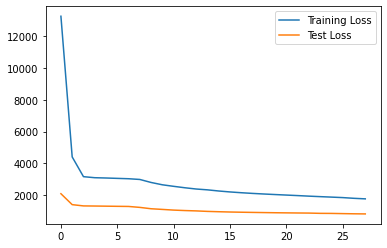

[29,     1] loss: 39.664
[29,     2] loss: 40.669
[29,     3] loss: 38.424
[29,     4] loss: 40.774
[29,     5] loss: 38.729
[29,     6] loss: 42.387
[29,     7] loss: 37.193
[29,     8] loss: 39.889
[29,     9] loss: 38.726
[29,    10] loss: 40.421
[29,    11] loss: 36.808
[29,    12] loss: 38.084
[29,    13] loss: 39.625
[29,    14] loss: 38.927
[29,    15] loss: 42.838
[29,    16] loss: 42.637
[29,    17] loss: 39.977
[29,    18] loss: 37.638
[29,    19] loss: 37.637
[29,    20] loss: 39.974
[29,    21] loss: 38.612
[29,    22] loss: 41.133
[29,    23] loss: 41.091
[29,    24] loss: 45.148
[29,    25] loss: 39.049
[29,    26] loss: 37.808
[29,    27] loss: 44.876
[29,    28] loss: 39.801
[29,    29] loss: 38.172
[29,    30] loss: 40.080
[29,    31] loss: 36.935
[29,    32] loss: 42.048
[29,    33] loss: 40.437
[29,    34] loss: 37.425
[29,    35] loss: 42.211
[29,    36] loss: 40.602
[29,    37] loss: 39.245
[29,    38] loss: 40.149
[29,    39] loss: 39.443
[29,    40] loss: 39.307


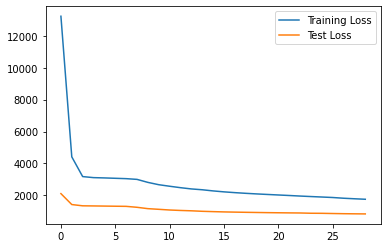

[30,     1] loss: 38.941
[30,     2] loss: 40.131
[30,     3] loss: 37.911
[30,     4] loss: 40.191
[30,     5] loss: 38.023
[30,     6] loss: 41.770
[30,     7] loss: 36.573
[30,     8] loss: 39.153
[30,     9] loss: 38.130
[30,    10] loss: 39.714
[30,    11] loss: 36.187
[30,    12] loss: 37.452
[30,    13] loss: 38.934
[30,    14] loss: 38.307
[30,    15] loss: 42.190
[30,    16] loss: 41.713
[30,    17] loss: 39.345
[30,    18] loss: 36.991
[30,    19] loss: 36.984
[30,    20] loss: 39.289
[30,    21] loss: 38.055
[30,    22] loss: 40.196
[30,    23] loss: 40.534
[30,    24] loss: 44.331
[30,    25] loss: 38.410
[30,    26] loss: 37.092
[30,    27] loss: 43.877
[30,    28] loss: 39.296
[30,    29] loss: 37.505
[30,    30] loss: 39.204
[30,    31] loss: 36.443
[30,    32] loss: 41.172
[30,    33] loss: 39.594
[30,    34] loss: 37.007
[30,    35] loss: 41.506
[30,    36] loss: 39.883
[30,    37] loss: 38.478
[30,    38] loss: 39.529
[30,    39] loss: 38.574
[30,    40] loss: 38.649


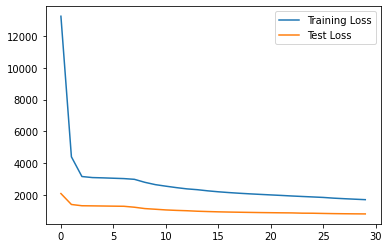

Finished Training


In [26]:
train_loss_graph = []
test_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)
          

print('Finished Training')

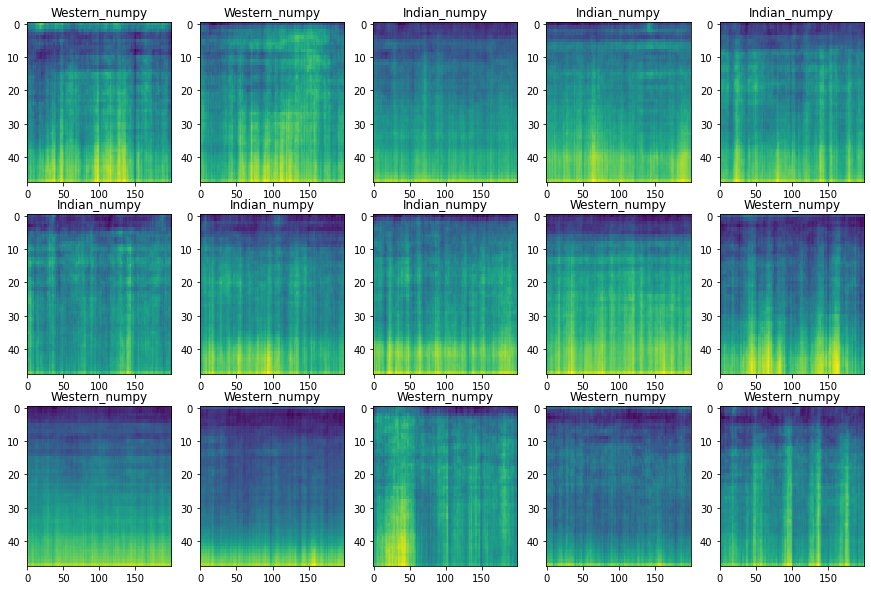

In [27]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

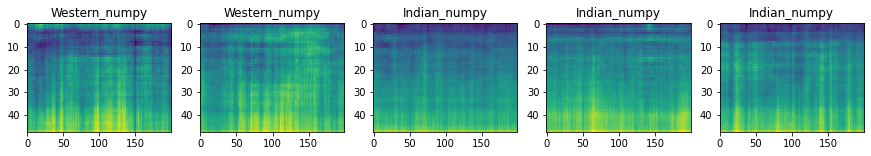

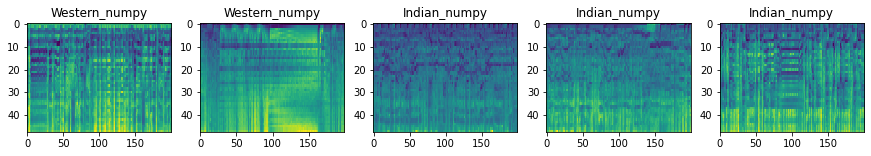

In [28]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [29]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [30]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Combined data set recinstruction

In [31]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict separation of training data set and test set

In [ ]:
id = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label in zip(inputs, output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(id) + ".npy"), np.transpose(orr48, (1,0)))
          id = id + 1


id = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label in zip(inputs, output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(id) + ".npy"), np.transpose(orr48, (1,0)))
          id = id + 1